In [1]:
import pandas

In [2]:
url = "https://data.urbansharing.com/oslobysykkel.no/trips/v1/2022/0{n}.csv"

In [3]:
data = pandas.concat([
pandas.read_csv(url.format(n=n), parse_dates=[0,1])
    for n in [4, 5, 6, 7]
])

In [4]:
data.to_csv('data_backup.csv')

In [5]:
!gzip data_backup.csv

data_backup.csv.gz already exists -- do you wish to overwrite (y or n)? ^C


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 636140 entries, 0 to 159260
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype              
---  ------                     --------------   -----              
 0   started_at                 636140 non-null  datetime64[ns, UTC]
 1   ended_at                   636140 non-null  datetime64[ns, UTC]
 2   duration                   636140 non-null  int64              
 3   start_station_id           636140 non-null  int64              
 4   start_station_name         636140 non-null  object             
 5   start_station_description  636124 non-null  object             
 6   start_station_latitude     636140 non-null  float64            
 7   start_station_longitude    636140 non-null  float64            
 8   end_station_id             636140 non-null  int64              
 9   end_station_name           636140 non-null  object             
 10  end_station_description    636124 non-null  object      

<AxesSubplot:ylabel='Frequency'>

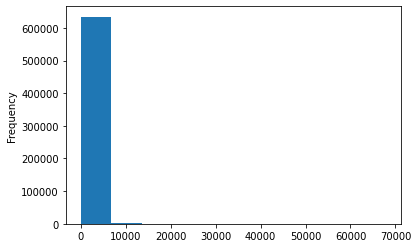

In [7]:
data['duration'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

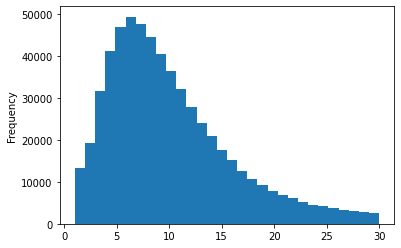

In [8]:
(data[data['duration'] < 60*30]['duration'] / 60).plot.hist(bins=30)

In [70]:
import numpy

<AxesSubplot:ylabel='Frequency'>

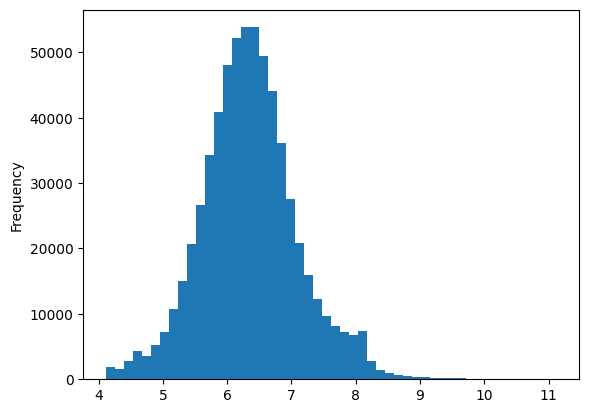

In [79]:
numpy.log(data['duration']).plot.hist(bins=50)

$X$ is log-normal, then $Y = \operatorname{log}(X)$ is normal.

In [84]:
import scipy
import matplotlib.pyplot as plt

In [81]:
mu,sigma = scipy.stats.norm.fit(numpy.log(data['duration']))

In [92]:
mu, sigma

(6.352490141794289, 0.7542569594679288)

<AxesSubplot:ylabel='Frequency'>

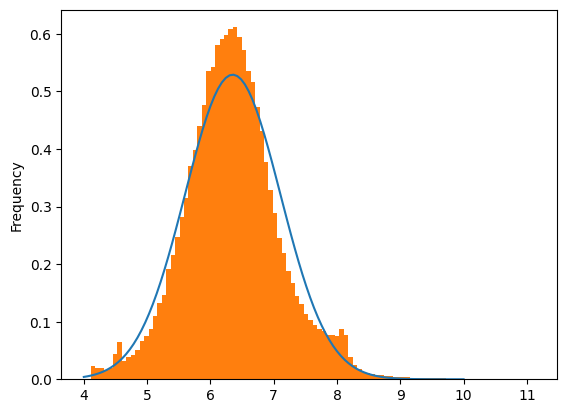

In [90]:
xs = numpy.linspace(4,10, 100)
plt.plot(xs, scipy.stats.norm(mu, sigma).pdf(xs))
numpy.log(data['duration']).plot.hist(density=True, bins=100)

In [102]:
s, loc, scale = scipy.stats.lognorm.fit(data['duration'], floc=0)

In [104]:
s

0.7542569594679288

In [105]:
numpy.log(scale)

6.352490141794289

In [106]:
lognorm = scipy.stats.lognorm(s, loc, scale)

In [111]:
lognorm.cdf(data['duration'].sort_values()[-20:])

array([0.99999989, 0.99999989, 0.9999999 , 0.9999999 , 0.9999999 ,
       0.99999991, 0.99999991, 0.99999992, 0.99999993, 0.99999993,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999995, 0.99999996, 0.99999997, 1.        , 1.        ])

## Interlude: Hypothesis testing

$H_0:$ There is no difference between days

$$X^2 = \sum_i \frac{(m_i - x_i)^2}{m_i},$$

where $m_i = p_i n$

$$X^2 \sim \chi^2 \quad \mathrm{if}\quad n \to \infty$$

In [122]:
per_day = data.groupby(pandas.Grouper(key='started_at', freq='D')).size()

<AxesSubplot:xlabel='started_at'>

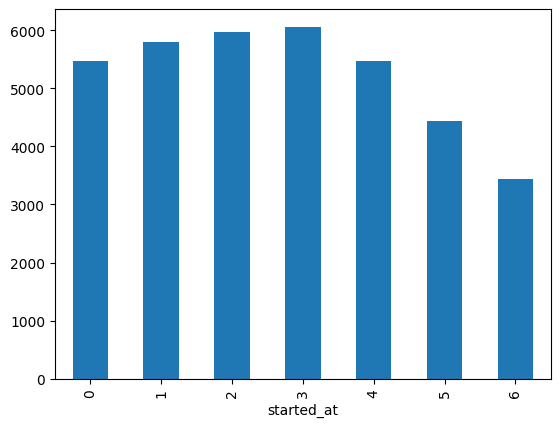

In [128]:
per_day.groupby(per_day.index.weekday).mean().plot.bar()

In [125]:
scipy.stats.chisquare(per_day.groupby(per_day.index.weekday).mean())

Power_divergenceResult(statistic=1058.8663573011704, pvalue=1.6531980573114888e-225)

In [129]:
scipy.stats.chisquare(per_day.groupby(per_day.index.weekday).mean()[1:4])

Power_divergenceResult(statistic=6.211900409342309, pvalue=0.04478194632172224)

In [ ]:
top_stations = data.groupby('start_station_name').size().sort_values(ascending=False)[:10].index

In [ ]:
pandas.get_dummies(
    data[data['start_station_name'].isin(top_stations)]
     [['duration', 'start_station_name']]).corr()['duration']

duration                                        1.000000
start_station_name_Aker Brygge                  0.092143
start_station_name_Alexander Kiellands Plass   -0.057831
start_station_name_Bislett Stadion             -0.032188
start_station_name_Bislettgata                 -0.050180
start_station_name_Helga Helgesens plass       -0.032839
start_station_name_Marcus Thranes gate         -0.028258
start_station_name_Olaf Ryes plass             -0.002869
start_station_name_Ringnes Park                -0.056157
start_station_name_Sukkerbiten                  0.067720
start_station_name_Tjuvholmen                   0.092851
Name: duration, dtype: float64

In [61]:
import seaborn as sns
plt.rcParams.update(plt.rcParamsDefault)

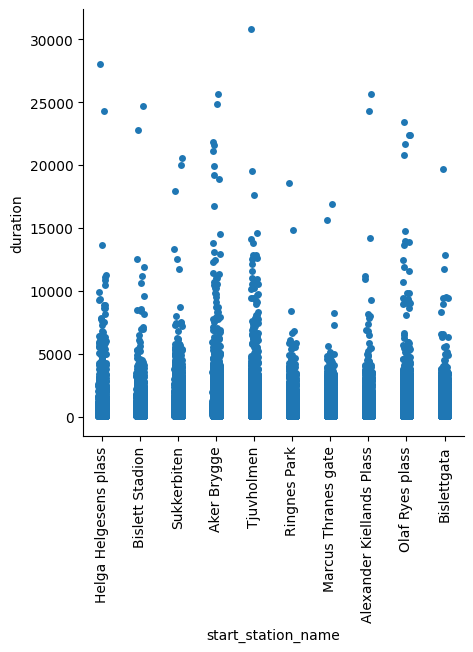

In [66]:
g = sns.catplot(data=data[data['start_station_name'].isin(top_stations)],
                x='start_station_name', y='duration')
g.set_xticklabels(rotation=90)

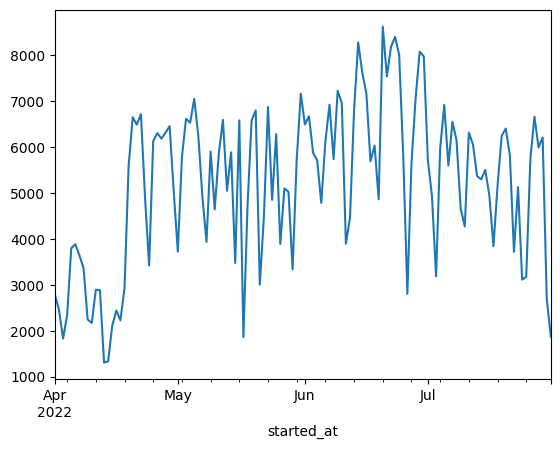

In [63]:
data.groupby(pandas.Grouper(key='started_at', freq='D')).size().plot()
None

<AxesSubplot:xlabel='started_at'>

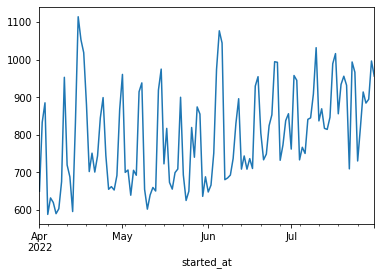

In [12]:
data.groupby(pandas.Grouper(key='started_at', freq='D')).mean()['duration'].plot()

In [13]:
data.groupby(pandas.Grouper(key='started_at', freq='H')).size()['2022-04']

started_at
2022-04-01 03:00:00+00:00      9
2022-04-01 04:00:00+00:00     53
2022-04-01 05:00:00+00:00    212
2022-04-01 06:00:00+00:00    336
2022-04-01 07:00:00+00:00    166
                            ... 
2022-04-30 19:00:00+00:00    183
2022-04-30 20:00:00+00:00    136
2022-04-30 21:00:00+00:00    135
2022-04-30 22:00:00+00:00     95
2022-04-30 23:00:00+00:00      1
Freq: H, Length: 717, dtype: int64

In [130]:
by_hour = data.groupby(pandas.Grouper(key='started_at', freq='h')).size()

In [131]:
by_hour.index.hour

Int64Index([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
            ...
            13, 14, 15, 16, 17, 18, 19, 20, 21, 22],
           dtype='int64', name='started_at', length=2924)

In [132]:
df_hourly = pandas.DataFrame({'date': by_hour.index.date,
                              'hour': by_hour.index.hour,
                              'count': by_hour})

In [133]:
df_hourly = df_hourly.pivot(index='date', columns='hour', values='count').fillna(0)

<AxesSubplot:xlabel='hour'>

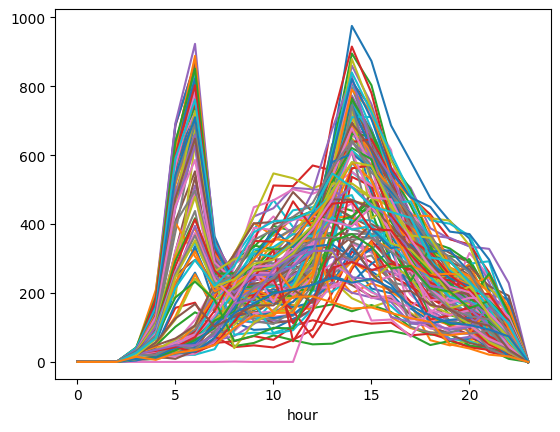

In [134]:
df_hourly.T.plot(legend=False)

In [135]:
from sklearn.cluster import KMeans

In [136]:
ks = list(range(1, 7))
scores = [KMeans(n_clusters=k).fit(df_hourly).inertia_ for k in ks]

In [137]:
import matplotlib.pyplot as plt

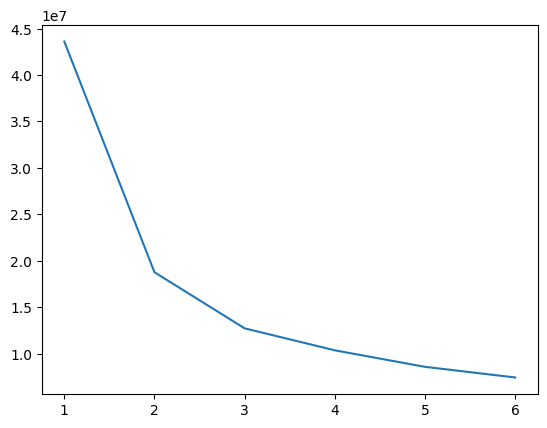

In [138]:
plt.plot(ks, scores)

In [139]:
model = KMeans(n_clusters=2).fit(df_hourly)

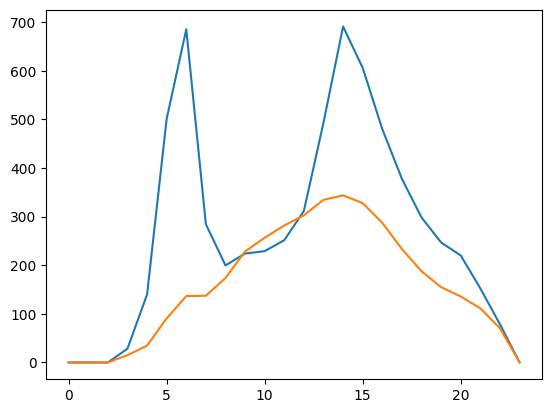

In [140]:
plt.plot(model.cluster_centers_.T)
None

In [141]:
model.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1], dtype=int32)

<AxesSubplot:>

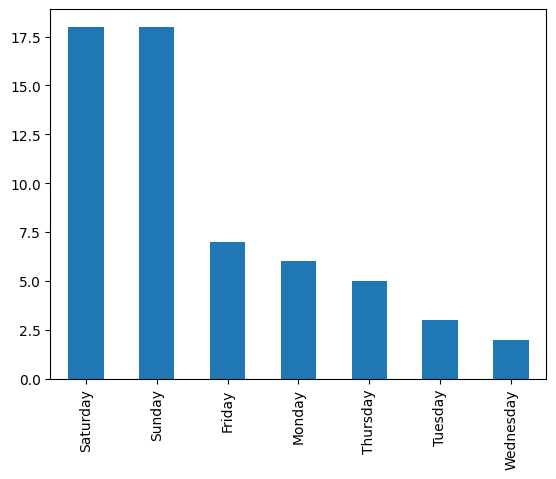

In [142]:
pandas.to_datetime(
    df_hourly.index
)[model.labels_.astype(bool)].day_name().value_counts().plot.bar()

In [149]:
model.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1], dtype=int32)

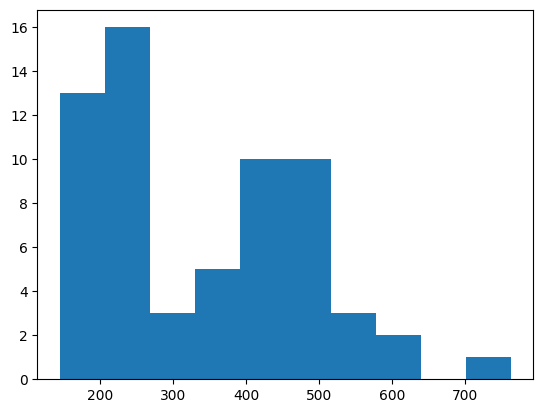

In [160]:
plt.hist(model.transform(df_hourly).min(axis=1)[model.labels_ == 0])
None

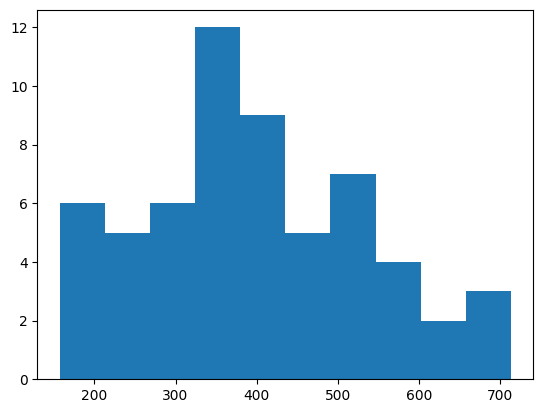

In [161]:
plt.hist(model.transform(df_hourly).min(axis=1)[model.labels_ == 1])
None

<AxesSubplot:>

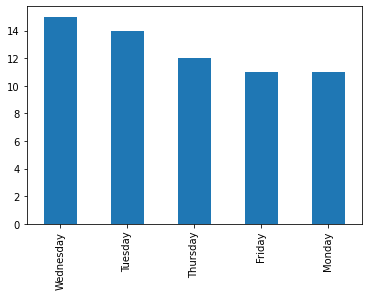

In [27]:
pandas.to_datetime(
    df_hourly.index
)[~model.labels_.astype(bool)].day_name().value_counts().plot.bar()

<AxesSubplot:xlabel='hour'>

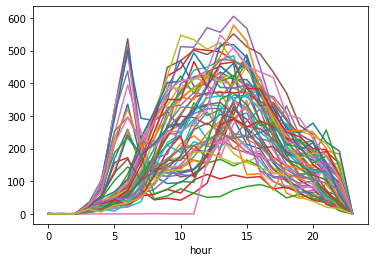

In [28]:
df_hourly.loc[model.labels_.astype(bool)].T.plot(legend=False)

<AxesSubplot:xlabel='hour'>

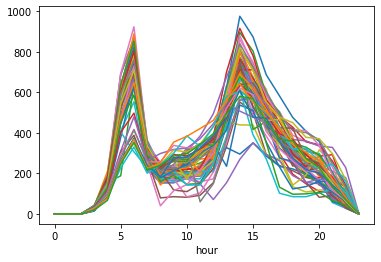

In [29]:
df_hourly.loc[~model.labels_.astype(bool)].T.plot(legend=False)

In [30]:
model.transform(df_hourly.loc[model.labels_.astype(bool)])[:,1]

array([464.34057675, 347.65081112, 494.97154689, 489.5854369 ,
       549.1181081 , 570.1547233 , 519.74297921, 491.98036515,
       396.55833139, 402.84299212, 357.24900165, 343.33008038,
       712.89762145, 632.62431754, 420.72480038, 350.16209568,
       388.62491397, 239.21397066, 359.68955781, 158.75020895,
       396.07791353, 194.84109569, 341.08682482, 187.3067864 ,
       663.89477548, 160.50809693, 593.31286373, 281.45186847,
       282.35670137, 251.86720007, 507.46814381, 353.53407291,
       198.6328741 , 530.33320357, 345.15005584, 663.28126434,
       445.6712154 , 287.76188078, 621.13941367, 380.04571763,
       516.83258119, 360.96988235, 384.51810258, 295.17613534,
       256.00447234, 246.8296641 , 448.08188382, 420.74421759,
       357.4971163 , 157.53778679, 376.17441189, 512.98602587,
       371.71303178, 387.5666176 , 295.2947709 , 241.27005411,
       575.09471735, 290.51926339, 482.90521058])

In [31]:
dists = model.transform(df_hourly.loc[~model.labels_.astype(bool)])[:,0]

In [32]:
((dists - dists.mean()) / dists.std())

array([-0.78796964, -0.83324417, -1.212171  , -1.29450939, -1.080962  ,
       -0.8622255 , -1.00141791, -1.25727101, -1.34620582, -0.89493939,
       -0.98897877, -0.82004629, -0.59120789, -0.81371207, -0.85426919,
        1.08074175,  0.22137857, -1.18454215,  0.85195814, -0.69403011,
        1.79687692, -1.12682528, -0.7525607 , -0.94784484,  2.98800997,
       -1.24097079,  0.15082107, -0.2739062 , -0.60145055, -0.50177185,
        0.88868128, -0.65673538,  0.52123458, -0.57486338, -0.83917743,
       -0.90345351,  1.01527193,  0.01202384,  0.13720549,  1.50519422,
        1.94634491,  0.03181317,  0.79294992,  1.10998766,  0.81144755,
       -0.19866631,  0.64233935,  0.52979995,  0.41647743,  0.91014153,
       -0.93760124, -1.27153341,  0.69471992, -0.44401846,  0.8258935 ,
        0.64488231,  0.56911951,  1.0495868 ,  1.04224017,  1.43466903,
        0.78872292,  1.37891509,  0.99963314])

## 3 Clusters

In [33]:
model = KMeans(n_clusters=3).fit(df_hourly)

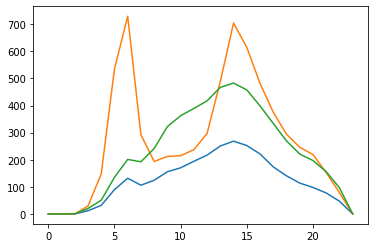

In [34]:
plt.plot(model.cluster_centers_.T)
None

In [35]:
model.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       2, 0, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2,
       0, 1, 0, 1, 1, 1, 0, 2, 1, 1, 1, 0, 2, 2, 0, 1, 1, 1, 1, 1, 2, 2,
       2, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 0, 1,
       1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2,
       2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0], dtype=int32)

<AxesSubplot:>

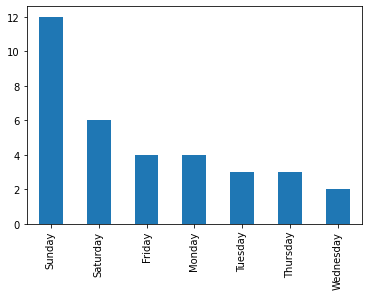

In [36]:
pandas.to_datetime(
    df_hourly.index
)[model.labels_ == 0].day_name().value_counts().plot.bar()

<AxesSubplot:>

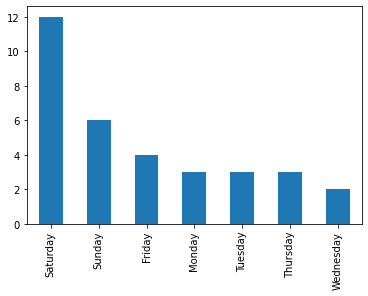

In [37]:
pandas.to_datetime(
    df_hourly.index
)[model.labels_ == 2].day_name().value_counts().plot.bar()

<AxesSubplot:>

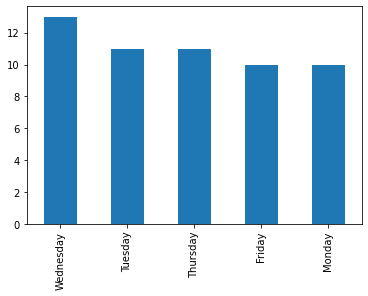

In [38]:
pandas.to_datetime(
    df_hourly.index
)[model.labels_ == 1].day_name().value_counts().plot.bar()

<AxesSubplot:xlabel='hour'>

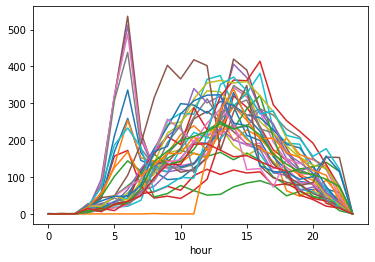

In [39]:
df_hourly.loc[model.labels_ == 0].T.plot(legend=False)

<AxesSubplot:xlabel='hour'>

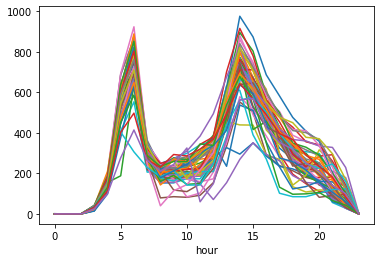

In [40]:
df_hourly.loc[model.labels_ == 1].T.plot(legend=False)

<AxesSubplot:xlabel='hour'>

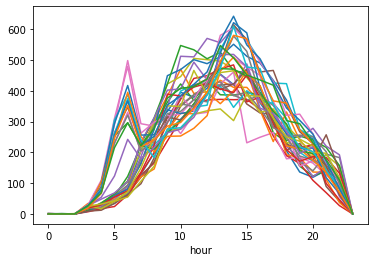

In [41]:
df_hourly.loc[model.labels_ == 2].T.plot(legend=False)

In [42]:
for cluster_number in [0,1,2]:
    dists = model.transform(
        df_hourly.loc[~model.labels_.astype(bool)])[:,cluster_number]
    print(sorted(((dists - dists.mean()) / dists.std())))

[-1.467506430650138, -1.3332812289622684, -1.117476162880016, -1.0263620561841529, -0.9632819458346955, -0.876725146327399, -0.8673366272510501, -0.8668302343285293, -0.8493182375105917, -0.8289605602613929, -0.7992379904673447, -0.7558165535806793, -0.3838834979569667, -0.3443022972852944, -0.3397395371282791, -0.3178244405555259, -0.30738913278950747, -0.29012534877982743, -0.18270887504440225, -0.1751258963377356, -0.043993169946059424, 0.015957666348755443, 0.38123939450870425, 0.4513130147152654, 0.507019551356595, 0.7521728476832916, 0.8206156235381602, 0.971425559534232, 1.0364105362790552, 1.494000412420138, 1.5038263383919894, 1.9343334031649637, 2.0619278872372915, 2.206983134883422]
[-2.35693033852592, -2.222354320682149, -1.8737569972272121, -1.5552348749925056, -1.3352368970296473, -0.6826200867659195, -0.6314375017450559, -0.5858444020022141, -0.5345372404843544, -0.48062941100754936, -0.4610163290111034, -0.2871691910938741, -0.14952402465134576, -0.13114779872923782, -0